In [102]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats

In [103]:
data = pd.read_csv('data\\Houses.csv', encoding='latin-1')

In [104]:
krakow_data = data[data.city == 'Kraków']
krakow_sm_data = krakow_data[krakow_data.address.str.contains('Stare Miasto')]
full_dataset = krakow_sm_data[['price', 'sq']]
full_dataset = full_dataset.reset_index()

In [105]:
size = full_dataset.shape[0]
test_size = int(size * 0.1)
test_dataset = full_dataset.loc[size-test_size:, :]
dataset = full_dataset.loc[:size-test_size - 1, :]

In [106]:
# dataset = dataset[dataset.sq <= 138]

usunięcie wartości odstających

In [107]:
q1 = np.quantile(dataset['price'], 0.25)
q3 = np.quantile(dataset['price'], 0.75)
iqr = q3 - q1

In [108]:
dataset = dataset[(dataset.price <= q3 + 1.5 * iqr) & (dataset.price >= q1 - 1.5 * iqr)]

usunięcie wartości odstających 2

In [109]:
price_to_surface = dataset.price / dataset.sq
dataset['ratio'] = price_to_surface

In [110]:
q1 = np.quantile(price_to_surface, 0.25)
q3 = np.quantile(price_to_surface, 0.75)
iqr = q3 - q1

In [111]:
# dataset = dataset[(dataset.ratio <= q3 + 1.5 * iqr) & (dataset.ratio >= q1 - 1.5 * iqr)]

współczynnik korelacji pearsona

This function also performs a test of the null hypothesis that the distributions underlying the samples are uncorrelated and normally distributed.

In [112]:
stats.pearsonr(dataset.sq, dataset.price)

PearsonRResult(statistic=0.8256410728371514, pvalue=4.7987017057797375e-146)

silna dodatnia korelacja

prosta regresji liniowej

In [113]:
surface = dataset.sq
price = dataset.price

In [114]:
def linear_regression(x, y):
    b1 = sum((x - np.mean(x)) * y) / sum((x - np.mean(x)) ** 2)
    b0 = np.mean(y) - b1 * np.mean(x)
    return b0, b1

In [115]:
a, b = linear_regression(surface, price)

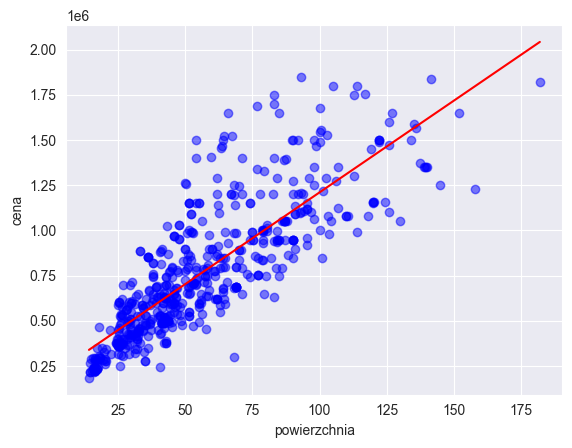

In [116]:
plt.scatter(surface,price, c='blue', alpha=0.5)
t = np.array([np.min(surface), np.max(surface)])
plt.plot(t, a + b * t, c='red')
plt.xlabel('powierzchnia')
_ = plt.ylabel('cena')

### Zadanie 5. Przedziały ufności

$\sigma$ nieznana

In [117]:
n = len(surface)
S = np.sqrt(np.sum((price - (a + b * surface)) ** 2) / (n - 2))

przedział ufności dla b1

In [118]:
alpha = 0.5
c = stats.t.ppf(1 - alpha/2, n-2) * S / np.sqrt(np.sum((surface - np.mean(surface))**2))

In [119]:
b - c, b + c

(9955.197635241182, 10344.271584943746)

przedział ufności dla b0

In [120]:
d = stats.t.ppf(1-alpha/2, n-2) * S * np.sqrt(1/n + np.mean(surface)**2/np.sum((surface - np.mean(surface))**2))

In [121]:
a - d, a + d

(183209.20591196473, 207909.62371110232)

### Zadanie 6. Analiza residuów

In [122]:
price_pred = a + b * surface  # estymatory Y
e = price - price_pred  # residua

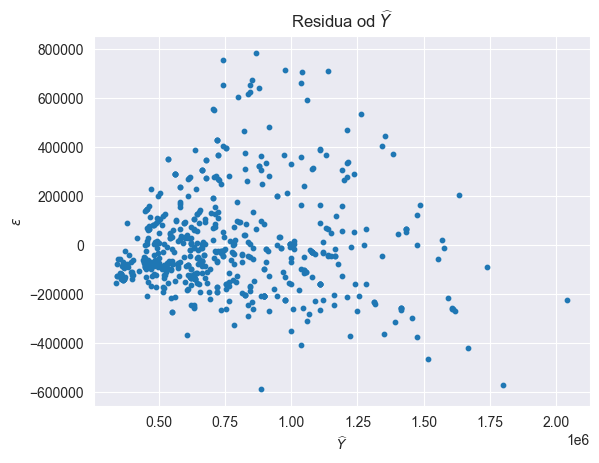

In [123]:
plt.title('Residua od $\widehat{Y}$')
plt.ylabel('$\epsilon$')
plt.xlabel('$\widehat{Y}$')
_ = plt.scatter(price_pred, e, s=10)

In [124]:
np.mean(e) # Średnia blisko 0

5.450080471071647e-11

In [125]:
print(stats.kstest(e/np.std(e), 'norm')) # nie mają rozkładu normalnego
print(stats.shapiro(e/np.std(e)))

KstestResult(statistic=0.1252847308935473, pvalue=2.082833097882297e-08, statistic_location=0.04190259655188683, statistic_sign=1)
ShapiroResult(statistic=0.9238955974578857, pvalue=1.479303602408029e-16)


In [126]:
import seaborn as sns

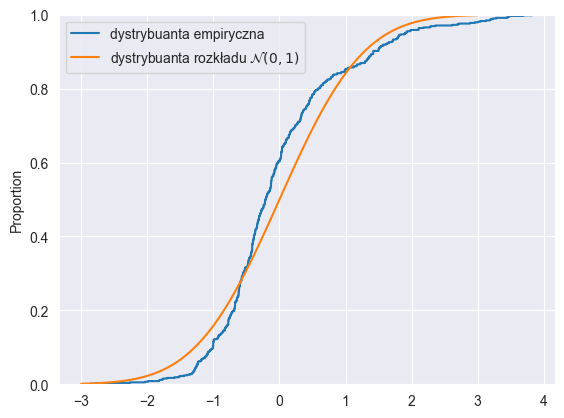

In [127]:
sns.ecdfplot(e/np.std(e))
t = np.linspace(-3, 3, 100)
plt.plot(t, stats.norm.cdf(t))
_ = plt.legend(['dystrybuanta empiryczna', 'dystrybuanta rozkładu $\mathcal{N}{(0, 1)}$'])

Widać, że wariancja nie jest stała. Heteroskedastyczność prawdopodobnie wynika z natury danych. Różnicy w cenach między dwoma małymi i tanimi mieszkaniami nie może być tak duża, jak między większymi i droższymi.

Często w przypadku heteroskedaktyczności jest logarytmowana zmienna objaśniana, żeby zmniejszyć lub zlikwidować efekt.

In [140]:
log_price = np.log(price)
log_surface = np.log(surface)

In [141]:
f, g = linear_regression(log_surface, log_price)

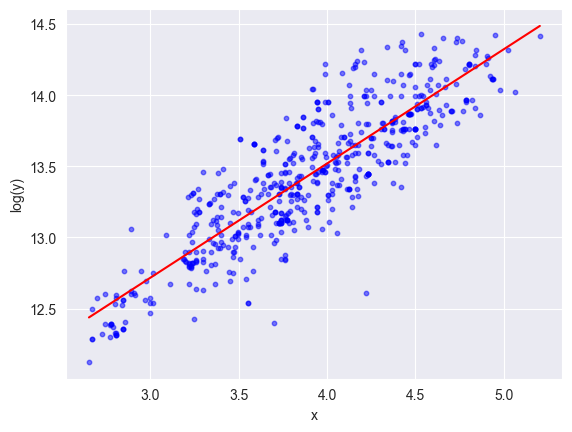

In [155]:
plt.scatter(log_surface, log_price, c='blue', alpha=0.5, s=10)
plt.xlabel('x')
plt.ylabel('log(y)')
t = np.array([np.min(log_surface), np.max(log_surface)])
_ = plt.plot(t, f + g * t, c='red')

In [145]:
log_e = log_price - (f + g * log_surface)

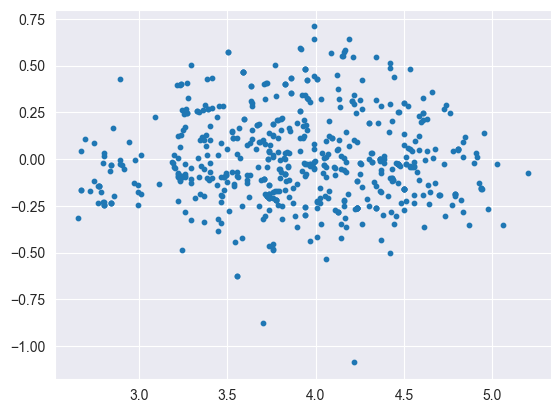

In [147]:
_ = plt.scatter(log_surface, log_e, s=10)

In [148]:
np.mean(log_e)

-2.415356115535625e-16

In [150]:
stats.kstest(log_e/np.std(log_e), 'norm')

KstestResult(statistic=0.0763774702205331, pvalue=0.0021492924434975743, statistic_location=0.048014073515943126, statistic_sign=1)

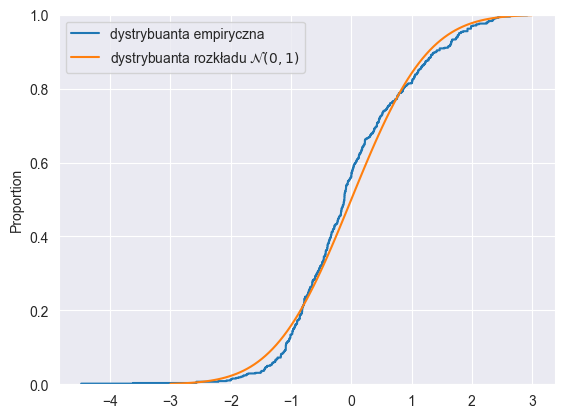

In [151]:
sns.ecdfplot(log_e/np.std(log_e))
t = np.linspace(-3, 3, 100)
plt.plot(t, stats.norm.cdf(t))
_ = plt.legend(['dystrybuanta empiryczna', 'dystrybuanta rozkładu $\mathcal{N}{(0, 1)}$'])

## Zadanie 7. Prognoza przyszłej wartości $Y{(x_0)}$

In [153]:
def confidence_interval(Y_est, s, x0, x, alpha=0.5):
    m = len(x)
    dummy1 = 1 + 1/m + (x0 - np.mean(x)) ** 2 / np.sum((x0 - np.mean(x)) ** 2)
    dummy2 = stats.t.ppf(1-alpha/2, m-2) * s * np.sqrt(dummy1)
    return Y_est - dummy2, Y_est + dummy2

In [154]:
def s(b0_est, b1_est, x, y):
    return np.sqrt(np.sum((y - b0_est - b1_est * x)**2) / (n - 2))

In [156]:
surface_test = test_dataset.sq
price_test = test_dataset.price

### Część 1 - bez logarytmów

In [ ]:
for new_surface in surface_test:
